# Tutorial: dynamic GRN inference from SHARE-seq dataset of mouse skin
# Step 1: trajectory inference with STREAM
This is a [Dictys](https://github.com/pinellolab/dictys) tutorial to reconstruct and analyze dynamic GRNs from the SHARE-seq dataset of mouse skin. This notebook is step 1 that infers the trajectory and pseudo-time of cell differentiation with STREAM and exports trajectory data to individual files for further processing by Dictys in main2.ipynb.

This is the same dataset as the one used in the paper, but you should not expect it reproduce the figures. This is because the tutorial aims to demonstrate the reconstruction of dynamic GRNs not provided in the paper. Use tutorial [analysis-skin](https://github.com/pinellolab/dictys/tree/master/doc/tutorials/analysis-skin) if you want to redraw the figures.

**You need to run this notebook in STREAM's own anaconda environment**. You can install STREAM [here](https://github.com/pinellolab/STREAM). This notebook is based on [its tutorial](https://nbviewer.org/github/pinellolab/STREAM/blob/master/tutorial/1.1.STREAM_scRNA-seq%20%28Bifurcation%29.ipynb?flush_cache=true).

Any trajectory inference software can be used as long as it outputs the trajectory (as nodes and edges) and each cell's location on the trajectory (either as edge & location on the trajectory, or as distance to each node). See different constructors of `dictys.traj.trajectory` and `dictys.traj.point`. Only tree-shaped trajectory is accepted.

If you face any issues or need any assistance, see [FAQ](https://github.com/pinellolab/dictys#faq) and [Issues](https://github.com/pinellolab/dictys#issues).


## Configuration
Note: this step may take **one hour or longer** depending on your network speed.

In [5]:
# Removes CPU usage limit by some jupyter versions
import os
os.environ['KMP_AFFINITY'] = ''
# Download network data from zenodo
# Replace *dictys* with your own environment name for Dictys
!. activate dictys && cd /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/pbmc_tut_swapnil && dictys_helper repodown.sh zenodo full-skin.tar.xz

## Load data

In [2]:
import os
import numpy as np
import pandas as pd
import anndata as ad

# Input file path of low-dimensional coordinates for cells to infer trajectory
data_dir_skin = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/tut_files/skin_data"
fname = os.path.join(data_dir_skin, 'coord_rna.tsv.gz')

# Load cell coordinates
d = pd.read_csv(fname, header=0, index_col=0, sep='\t')
ns = d.shape[0]

# Load cell subset information
d['label'] = None
subsets_file = os.path.join(data_dir_skin, 'subsets.txt')

with open(subsets_file, 'r') as f:
    subsets_name = [x.strip() for x in f.readlines()]

cells = set(d.index)
for subset in subsets_name:
    subset_file = os.path.join(data_dir_skin, 'subsets', subset, 'names_rna.txt')
    with open(subset_file, 'r') as f:
        c = [x.strip() for x in f.readlines()]
    c = set(c) & cells
    d.loc[c, 'label'] = subset

# Construct adata only with coordinates and subsets (low dim coordinates + cell-type labels)
adata = ad.AnnData(np.array([]).reshape(ns, 0))
adata.obs = d[['label']].copy()
adata.obsm['X_dr'] = d[['x', 'y']].values.copy()


/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/anndata/core/anndata.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [3]:
adata

AnnData object with n_obs × n_vars = 6436 × 0 
    obs: 'label'
    obsm: 'X_dr'

In [4]:
adata.X #empty

array([], shape=(6436, 0), dtype=float32)

In [3]:
print(adata.obs.head())

                                        label
Trial60.skin.R1.01.R2.02.R3.21.P1.56      IRS
Trial60.skin.R1.01.R2.03.R3.61.P1.54  Medulla
Trial60.skin.R1.01.R2.06.R3.64.P1.56    TAC-2
Trial60.skin.R1.01.R2.06.R3.83.P1.55    TAC-1
Trial60.skin.R1.01.R2.11.R3.86.P1.56    TAC-1


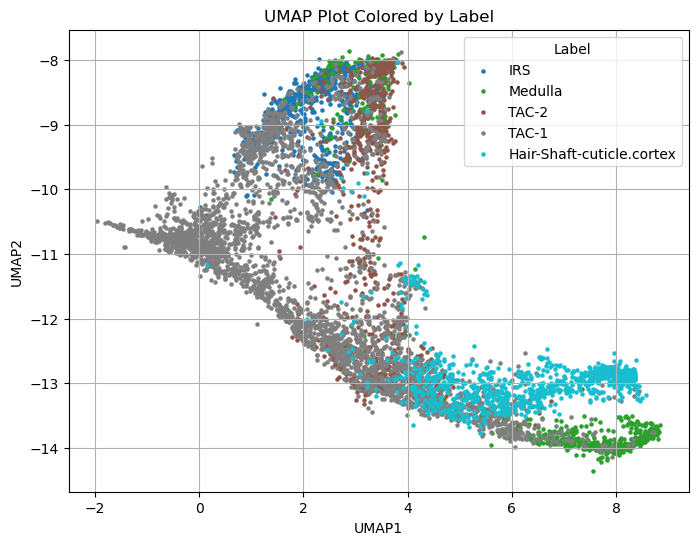

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr' slot (assuming this contains UMAP data)
umap_coords = adata.obsm['X_dr']

# Extract the labels for coloring
labels = adata.obs['label']

# Assign a unique color to each label
unique_labels = labels.unique()
colors = plt.cm.get_cmap('tab10', len(unique_labels))  # You can choose different colormaps

# Plotting the UMAP with colors based on labels
plt.figure(figsize=(8, 6))

for i, label in enumerate(unique_labels):
    idx = labels == label
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], c=np.array([colors(i)]), label=label, s=5)

plt.title('UMAP Plot Colored by Label')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.grid(True)
plt.legend(title="Label")
plt.show()


## Trajectory inference

In [5]:
import os
os.environ["OMP_NUM_THREADS"] = "128"
from tempfile import TemporaryDirectory
import stream as st

# Parameters for STREAM
ka1={'epg_alpha':0.05,'epg_mu':0.01,'epg_lambda':0.1,'epg_trimmingradius':2}
ka2={'epg_ext_mode':'QuantDists','epg_ext_par':1.}
from rpy2.robjects import r

# Load the rlang package in R
r('library(rlang)')

# Trajectory inference
with TemporaryDirectory() as td:
	st.set_workdir(adata,td)
	st.elastic_principal_graph(adata,**ka1)
	st.extend_elastic_principal_graph(adata,**ka2)
	

Saving results in: /tmp/tmppq4_286d
No initial structure is seeded
Learning elastic principal graph...
[1]
 "Generating the initial configuration"


[1]
 "Creating a chain in the 1st PC with 2 nodes"


[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "The elastic matrix is being used. Edge configuration will be ignored"


[1]
 "Computing EPG with 50 nodes on 6436 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
2
 
3
 
4
 
5
 
6
 
7
 
8
 
9
 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1||50
	
0.5861
	
50
	
49
	
46
	
1
	
0
	
0
	
0.267
	
0.2634
	
0.9726
	
0.973
	
0.3076
	
0.0115
	
0.5748
	
28.74
	
0




/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

  warnings.warn(x, RRuntimeWarning)


23.695 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 3
Extending leaves with additional nodes ...
Number of branches after extending leaves: 3


## Trajectory visualization
Use this step to determine whether you are happy with the inferred trajectory, and rerun the previous step with different parameters as needed.

Note: **record cell type/developmental stage annotations** of the nodes (S0, ...) for future dynamic GRN analyses.

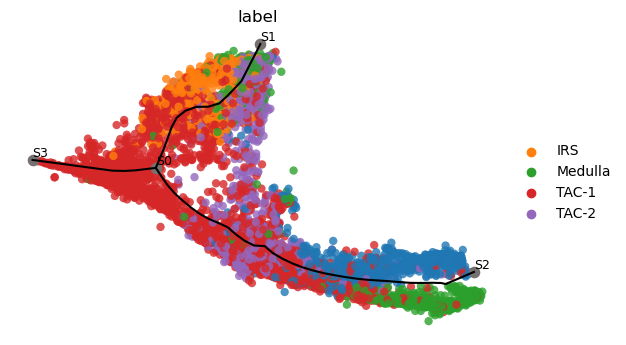

In [6]:
import matplotlib.pyplot as plt

st.plot_dimension_reduction(adata,show_graph=True,show_text=True,color=['label'])
ax=plt.gca()
ax.set_aspect(1)
ax.axis('off');


In this trajectory, S3 (TAC-1) is the starting point of differentiation and S1, S2 are two terminal states.

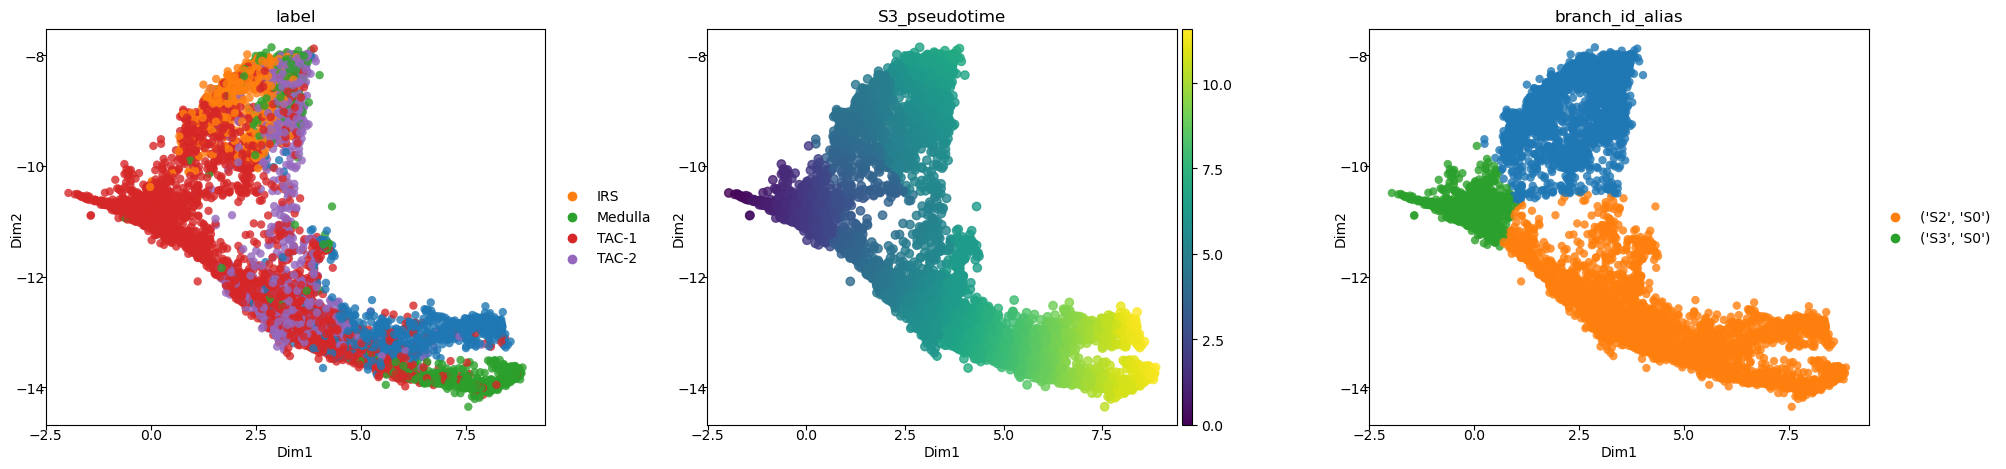

In [7]:
#Replace S3 with your own starting node if on a different dataset
st.plot_dimension_reduction(adata,color=['label','S3_pseudotime','branch_id_alias'])


In [14]:
adata.obs.head()

,label,node,branch_id,branch_id_alias,branch_lam,branch_dist,S0_pseudotime,S2_pseudotime,S1_pseudotime,S3_pseudotime
Trial60.skin.R1.01.R2.02.R3.21.P1.56,IRS,22,"(52, 2)","('S1', 'S0')",2.377683,0.486079,1.796973,10.384121,2.377683,4.781205
Trial60.skin.R1.01.R2.03.R3.61.P1.54,Medulla,42,"(51, 2)","('S2', 'S0')",0.528227,0.538389,8.058921,0.528227,12.233577,11.043153
Trial60.skin.R1.01.R2.06.R3.64.P1.56,TAC-2,48,"(52, 2)","('S1', 'S0')",0.735645,0.356885,3.439011,12.026159,0.735645,6.423243
Trial60.skin.R1.01.R2.06.R3.83.P1.55,TAC-1,33,"(52, 2)","('S1', 'S0')",3.146313,0.093121,1.028344,9.615491,3.146313,4.012575
Trial60.skin.R1.01.R2.11.R3.86.P1.56,TAC-1,26,"(52, 2)","('S1', 'S0')",2.496962,0.392899,1.677695,10.264842,2.496962,4.661926


In [15]:
# save anndata object
adata.write('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/tut_files/skin_data/adata_with_traj.h5ad')

/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/anndata/core/anndata.py:108: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif is_categorical(df[k]):
/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/anndata/readwrite/write.py:264: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = np.array(value)  # make sure value is an array
/ocean/projects/cis240075p/asachan/.conda/envs/env_stream/lib/python3.7/site-packages/anndata/readwrite/write.py:316: UserWarning: Could not save field with key = 'uns/epg_obj' to hdf5 file: Can't implicitly convert non-string objects to strings
  .format(key, e)
/ocean/projects/cis240075p/asac

## Output trajectory

In [5]:
# Extract node names from pseudotime columns
import numpy as np
import pandas as pd

dimnodes=np.array(sorted([x[:-len('_pseudotime')] for x in adata.obs.columns if x.endswith('_pseudotime')]))
# Create a distance matrix between cells and nodes (cell by node, value is pseudotime distance)
dist=np.array([adata.obs.loc[d.index,x+'_pseudotime'].values for x in dimnodes]).T
node_dict=dict(zip(dimnodes,range(len(dimnodes))))

# Map branch_id_alias to numeric indices based on node names
branch = np.array([sorted([node_dict.get(y.strip('() \''), None) for y in eval(x)]) for x in adata.obs.loc[d.index, 'branch_id_alias']])
# The branch each cell is on (cell:(node_start,node_end))
branch=pd.DataFrame(branch,index=d.index)
#branch.to_csv('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/tut_files/skin_data/tmp/branch.tsv.gz',header=False,index=False,sep='\t')

# Identify and save unique edges between nodes
edge=np.unique(branch.values,axis=0)
edge=pd.DataFrame(edge)
#edge.to_csv('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/tut_files/skin_data/tmp/edge.tsv.gz',header=False,index=False,sep='\t')

dist=pd.DataFrame(dist,index=d.index,columns=dimnodes)
#dist.to_csv('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/tut_files/skin_data/tmp/dist.tsv.gz',header=True,index=True,sep='\t')


NameError: name 'd' is not defined

#### Inspect traj outfiles format for dictys

In [7]:
# load files
branch_tsv = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/tut_files/skin_data/tmp/branch.tsv.gz'
edge_tsv = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/tut_files/skin_data/tmp/edge.tsv.gz'
dist_tsv = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/tut_files/skin_data/tmp/dist.tsv.gz'


In [11]:
#load to pandas tsv
branch = pd.read_csv(branch_tsv, header=None, index_col=0, sep='\t')

In [12]:
# load to pandas tsv
edge = pd.read_csv(edge_tsv, header=None, index_col=None, sep='\t')

In [13]:
# load to pandas tsv
dist = pd.read_csv(dist_tsv, header=0, index_col=0, sep='\t')

In [10]:
print(branch.head(50))
print(branch.shape)

   1
0   
0  1
0  2
0  1
0  1
0  1
0  2
0  1
0  3
0  2
0  2
0  1
0  1
0  2
0  1
0  2
0  2
0  3
0  2
0  2
0  2
0  1
0  3
0  1
0  2
0  2
0  3
0  2
0  2
0  3
0  2
0  3
0  2
0  1
0  2
0  2
0  1
0  2
0  2
0  2
0  1
0  2
0  3
0  2
0  2
0  3
0  1
0  1
0  2
0  2
0  2
(6436, 1)


In [14]:
print(edge.head(50))
print(edge.shape)

   0  1
0  0  1
1  0  2
2  0  3
(3, 2)


In [15]:
print(dist.head(50))
print(dist.shape)

                                            S0         S1         S2  \
Trial60.skin.R1.01.R2.02.R3.21.P1.56  1.796973   2.377683  10.384121   
Trial60.skin.R1.01.R2.03.R3.61.P1.54  8.058921  12.233577   0.528227   
Trial60.skin.R1.01.R2.06.R3.64.P1.56  3.439011   0.735645  12.026159   
Trial60.skin.R1.01.R2.06.R3.83.P1.55  1.028344   3.146313   9.615491   
Trial60.skin.R1.01.R2.11.R3.86.P1.56  1.677695   2.496962  10.264842   
Trial60.skin.R1.01.R2.15.R3.09.P1.55  2.251524   6.426180   6.335624   
Trial60.skin.R1.01.R2.17.R3.81.P1.53  1.756870   2.417786  10.344018   
Trial60.skin.R1.01.R2.18.R3.95.P1.54  0.798474   4.973130   9.385622   
Trial60.skin.R1.01.R2.19.R3.59.P1.55  3.320269   7.494925   5.266879   
Trial60.skin.R1.01.R2.20.R3.02.P1.54  5.871168  10.045824   2.715980   
Trial60.skin.R1.01.R2.21.R3.25.P1.54  2.590872   1.583784  11.178020   
Trial60.skin.R1.01.R2.22.R3.38.P1.54  2.988921   1.185735  11.576069   
Trial60.skin.R1.01.R2.23.R3.50.P1.54  3.582359   7.757015   5.00